<a href="https://colab.research.google.com/github/tuanlamdao/datascience/blob/master/13_Models_that_engineer_features_for_us.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tuanlam import *

In [ ]:
kwargs = {'test_size': .25, 'random_state':42}

In [ ]:
iris = datasets.load_iris()
tts = skms.train_test_split(iris.data, iris.target, **kwargs)
(iris_train, iris_test, iris_train_tgt, iris_test_tgt) = tts

In [ ]:
wine = datasets.load_wine()
tts = skms.train_test_split(wine.data, wine.target, **kwargs)
(wine_train, wine_test, wine_train_tgt, wine_test_tgt) = tts

In [ ]:
diabetes = datasets.load_diabetes()
tts = skms.train_test_split(diabetes.data, diabetes.target, **kwargs)
(diabetes_train, diabetes_test, diabetes_train_tgt, diabetes_test_tgt) = tts

In [ ]:
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
wine_df = pd.DataFrame(wine.data, columns=wine.feature_names)
diabetes_df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)

### Feature selection
there are 3 ways top pick features:
1. evaluation each feature in isolation, then select some and discard the rest
2. select one or more features, build a model, and assess the results. Repeat after adding or removing features. 
3. as part of the model building process, we can select or ignore different features

way 1

In [ ]:
print(wine_df.var())

alcohol                                      0.6591
malic_acid                                   1.2480
ash                                          0.0753
alcalinity_of_ash                           11.1527
magnesium                                  203.9893
total_phenols                                0.3917
flavanoids                                   0.9977
nonflavanoid_phenols                         0.0155
proanthocyanins                              0.3276
color_intensity                              5.3744
hue                                          0.0522
od280/od315_of_diluted_wines                 0.5041
proline                                 99,166.7174
dtype: float64


Checking variance wine data set above, we can get rid of features with very low variance

let pick out those features that have a variance greater than one

In [ ]:
varsel = ftr_sel.VarianceThreshold(threshold=1)
varsel.fit_transform(wine_train)
print("First example")
print(varsel.fit_transform(wine_train)[0],wine_train[0,wine_train.var(axis=0)>1],sep='\n')

First example
[   2.36   18.6   101.      3.24    5.68 1185.  ]
[   2.36   18.6   101.      3.24    5.68 1185.  ]


so, running the VarianceThreshold.fit_transform is effectively the same as picking the columns with variance greater than one.

In [ ]:
print(varsel.get_support())

[False  True False  True  True False  True False False  True False False
  True]


In [ ]:
keepers_idx = varsel.get_support()
keepers = np.array(wine.feature_names)[keepers_idx]
print(keepers)

['malic_acid' 'alcalinity_of_ash' 'magnesium' 'flavanoids'
 'color_intensity' 'proline']


Using get_support() as above will provide feature names to keep.Evaluating each feature isolation involves some issues and could provide incorrect kept features. 


##### Correlation

In [ ]:
n = len(diabetes_train)
x = diabetes_train_tgt[np.newaxis,:]
y = diabetes_train
cov_via_dot = np.dot(x-x.mean(), y-y.mean())/n
cov_via_np = np.cov(diabetes_train, diabetes_train_tgt, rowvar=False, bias=True)[-1,:-1]
print(np.allclose(cov_via_dot, cov_via_np))

True


In general: Variance is ok, but covariance is a big improvement

[0.6811 0.    ]


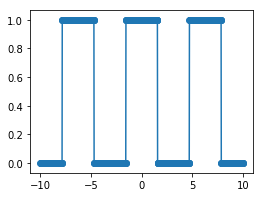

In [ ]:
xs = np.linspace(-10,10,1000).reshape(-1,1)
data = np.c_[xs,np.random.uniform(-10,10,xs.shape)]
tgt = (np.cos(xs)>0).flatten()
plt.figure(figsize=(4,3))
plt.scatter(data[:,0],tgt)
plt.plot(data[:,0],tgt)
mi = ftr_sel.mutual_info_classif(data,tgt,discrete_features=False)
print(mi)

We can select the top features by using method SelectKBest with mutual_info_classif or f_classif which provide most the same of top 5 features

In [ ]:
ftrsel = ftr_sel.SelectKBest(ftr_sel.mutual_info_classif, k=5)
ftrsel.fit_transform(wine_train, wine_train_tgt)
keepers_idx = ftrsel.get_support()
print(np.array(wine.feature_names)[keepers_idx])

['flavanoids' 'color_intensity' 'hue' 'od280/od315_of_diluted_wines'
 'proline']


In [ ]:
ftrsel = ftr_sel.SelectKBest(ftr_sel.f_classif, k=5)
ftrsel.fit_transform(wine_train, wine_train_tgt)
keepers_idx = ftrsel.get_support()
print(np.array(wine.feature_names)[keepers_idx])

['alcohol' 'flavanoids' 'color_intensity' 'od280/od315_of_diluted_wines'
 'proline']


if we prefer to grab some percentage of the features, we can use SelectionPercentile combining with r2. Here are what we have with diabetes dataset 

In [ ]:
ftrsel = ftr_sel.SelectPercentile(ftr_sel.f_regression, percentile=25)
ftrsel.fit_transform(diabetes_train, diabetes_train_tgt)
keepers_idx = ftrsel.get_support()
print(np.array(diabetes.feature_names)[keepers_idx])

['bmi' 'bp' 's5']


In [ ]:
ftrsel = ftr_sel.SelectPercentile(ftr_sel.mutual_info_classif, percentile=25)
ftrsel.fit_transform(diabetes_train, diabetes_train_tgt)
keepers_idx = ftrsel.get_support()
print(np.array(diabetes.feature_names)[keepers_idx])

['sex' 's4' 's5']


##### Model based feature selection

In [ ]:
ftrsel = ftr_sel.SelectFromModel(ensemble.RandomForestClassifier(), threshold='mean')
ftrsel.fit_transform(wine_train, wine_train_tgt)
print(np.array(wine.feature_names)[ftrsel.get_support()])

['alcohol' 'flavanoids' 'color_intensity' 'hue'
 'od280/od315_of_diluted_wines' 'proline']


For models with L1 regularization - that's what we called the lasso , the default threshold is small coefficients

In [ ]:
lmlr = linear_model.LogisticRegression
ftrsel = ftr_sel.SelectFromModel(lmlr(penalty='l1'))
ftrsel.fit_transform(wine_train, wine_train_tgt)
print(np.array(wine.feature_names)[ftrsel.get_support()])

['alcohol' 'malic_acid' 'ash' 'alcalinity_of_ash' 'magnesium' 'flavanoids'
 'proanthocyanins' 'color_intensity' 'od280/od315_of_diluted_wines'
 'proline']


using method called Recursive feature elimination which is available through RFE. Here we will use a RandomForestClassifier as the underlying model. Random forest operate by repeatedly working with random selections of the features. If a feature shows up in many of the component trees we can use that as an indicator that a more frequently used feature 

In [ ]:
ftrsel = ftr_sel.RFE(ensemble.RandomForestClassifier(), n_features_to_select=5)
res = ftrsel.fit_transform(wine_train, wine_train_tgt)
print(np.array(wine.feature_names)[ftrsel.get_support()])


['alcohol' 'flavanoids' 'color_intensity' 'od280/od315_of_diluted_wines'
 'proline']


In [ ]:
ftrsel = ftr_sel.RFE(linear_model.LinearRegression(), n_features_to_select=5)
ftrsel.fit_transform(wine_train, wine_train_tgt)
print(np.array(wine.feature_names)[ftrsel.get_support()])

['alcohol' 'total_phenols' 'flavanoids' 'hue'
 'od280/od315_of_diluted_wines']


We can use .ranking_to order the dropped features.

In [ ]:
print(ftrsel.ranking_, ftrsel.estimator_.coef_,sep='\n')

[1 5 2 4 9 1 1 3 7 6 1 1 8]
[-0.2164  0.1281 -0.3936 -0.6394 -0.3572]


Here the 1s in the ranking are selected: they are our keepers. The non 1s indicate when that feature was dropped. The five 1s can be ordered based on the absolute value to the five estimator coefficients

In [ ]:
keepers_ibx = np.argsort(np.abs(ftrsel.estimator_.coef_))
keepers_order_idx = np.where(ftrsel.ranking_ == 1 )
print(np.array(wine.feature_names)[keepers_order_idx])

['alcohol' 'total_phenols' 'flavanoids' 'hue'
 'od280/od315_of_diluted_wines']


##### Integrating feature selection with a learning pipeline
we can put together feature selection and model building in a pipeline and see how various combinations do

In [ ]:
skms.cross_val_score(linear_model.LogisticRegression(), wine.data, wine.target)

array([0.8667, 0.95  , 1.    ])

In [ ]:
lmlr = linear_model.LogisticRegression
ftrsel = ftr_sel.SelectFromModel(lmlr(penalty='l1'))
pipe = pipeline.make_pipeline(ftrsel, linear_model.LogisticRegression())
skms.cross_val_score(pipe, wine.data, wine.target)

array([0.8667, 0.95  , 1.    ])

that's definitve no. we will check if using a different learning model to pick features helps:

In [ ]:
ftrsel = ftr_sel.RFE(ensemble.RandomForestClassifier(), n_features_to_select=5)
pipe = pipeline.make_pipeline(ftrsel, linear_model.LogisticRegression())
skms.cross_val_score(pipe,wine.data,wine.target)

array([0.8667, 0.9167, 0.9655])

again, the answer is no, but it was not hard to do and it could potentially help in other problems,let's switch to using an information -based features evaluator:

In [ ]:
ftrsel = ftr_sel.SelectPercentile(ftr_sel.mutual_info_classif, percentile=25)
pipe = pipeline.make_pipeline(ftrsel, linear_model.LogisticRegression())
skms.cross_val_score(pipe, wine.data, wine.target)

array([0.9167, 0.9167, 1.    ])

it seems to help a bit but we need to do a bit more experimentation to be sold on making it part of our pipeline.Let fine turn the number of features we keep. WE can do that with a GridSearch ont the pipeline 

In [ ]:
ftrsel = ftr_sel.SelectPercentile(ftr_sel.mutual_info_classif, percentile=25)
pipe = pipeline.make_pipeline(ftrsel, linear_model.LogisticRegression())

param_grid = {'selectpercentile__percentile': [5,10,15,20,25]}
grid = skms.GridSearchCV(pipe, param_grid=param_grid, cv=3, iid=False)


In [ ]:
grid.fit(wine.data, wine.target)

print(grid.best_params_)
print(grid.best_score_)

ValueError: Invalid parameter selectpercentile_percentile for estimator Pipeline(memory=None,
     steps=[('selectpercentile', SelectPercentile(percentile=25,
         score_func=<function mutual_info_classif at 0x7f12e5eeed90>)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]). Check the list of available parameters with `estimator.get_params().keys()`.

##### Feature construction with Kernels
we 'll make a simple classification problem that determines whether or not a point is inside or outside of a circle

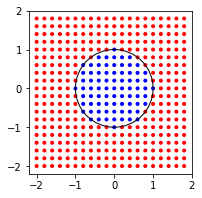

In [ ]:
xs, ys = np.mgrid[-2:2:.2, -2:2:.2]
tgt = (xs**2 + ys**2 > 1).flatten()
data = np.c_[xs.flat, ys.flat]
fig, ax = plt.subplots(figsize=(4,3))
ax.scatter(xs, ys, c=np.where(tgt, 'r','b'),marker='.')
ax.set_aspect('equal')

circ = plt.Circle((0,0), 1, color='k', fill=False)
ax.add_patch(circ)

if we look at the performance of 2 linear methods, SVC and logistic regression

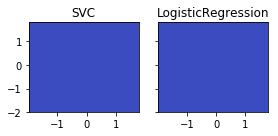

In [ ]:
shootout_linear = [svm.SVC(kernel='linear'), linear_model.LogisticRegression()]
fig, axes = plt.subplots(1,2, figsize=(4,2), sharey=True)
for mod, ax in zip(shootout_linear, axes):
    plot_boundary(ax, data, tgt, mod, [0,1])
    ax.set_title(get_model_name(mod))
plt.tight_layout()

both of them always predict blue means - everything is labled as being in the circle. Let look at  non linear learning methods KNN and decision trees to see if they do it better

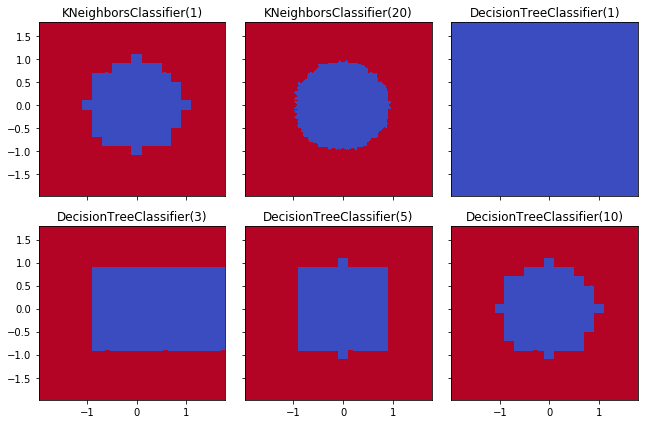

In [ ]:
knc_p, dtc_p = [1,20],[1,3,5,10]
KNC = neighbors.KNeighborsClassifier
DTC = tree.DecisionTreeClassifier
shootout_nonlin = ([(KNC(n_neighbors=p),p) for p in knc_p] + [(DTC(max_depth=p), p ) for p in dtc_p])

fig, axes = plt.subplots(2,3, figsize=(9,6), sharex=True, sharey=True)
for (mod, param), ax in zip(shootout_nonlin, axes.flat):
    plot_boundary(ax, data, tgt, mod, [0,1])
    ax.set_title(get_model_name(mod) + "({})".format(param))
plt.tight_layout()

our non-linear classifier do it much better

Manual Kernel Methods: the following code demonstrate what a kernel does and how it help to construct good features

In [ ]:
k_data = metrics.pairwise.polynomial_kernel(data, data, degree=2)
print('first example:', data[0])
print('features in original form:', data[0].shape)
print('features with kernel form:', k_data[0].shape)
print('example in both:', len(data), len(k_data))

first example: [-2. -2.]
features in original form: (2,)
features with kernel form: (400,)
example in both: 400 400


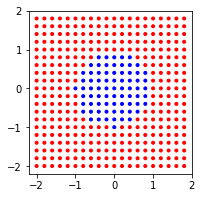

In [ ]:
fig, ax = plt.subplots(figsize=(4,3))
preds = (linear_model.LogisticRegression().fit(k_data,tgt).predict(k_data))
ax.scatter(xs, ys, c=np.where(preds, 'r', 'b'), marker='.')
ax.set_aspect('equal')

with manual kernel applied, we seems to be getting perfect prediction

In [ ]:
from sklearn.base import TransformerMixin
class PolyKernel(TransformerMixin):
    def __init__(self,degree):
        self.degree = degree
    def transform(self, ftrs):
        pk = metrics.pairwise.pairwise_kernels
        return pk(ftrs, self.ftrs, metric = 'poly', degree = self.degree)
    def fit(self, ftrs, tgt = None):
        self.ftrs = ftrs
        return self


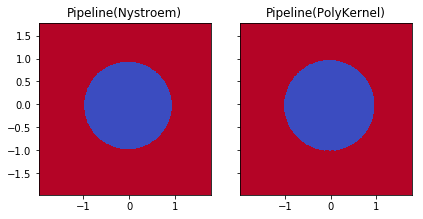

In [ ]:
from sklearn import kernel_approximation
kn = kernel_approximation.Nystroem(kernel='polynomial', degree=2, n_components=6)
LMLR = linear_model.LogisticRegression()
k_logreg1 = pipeline.make_pipeline(kn, LMLR)
k_logreg2 = pipeline.make_pipeline(PolyKernel(2), LMLR)
shootout_fancy = [(k_logreg1, 'Nystroem'),(k_logreg2, 'PolyKernel')]
fig, axes = plt.subplots(1,2,figsize=(6,3), sharey=True)

for (mod, kernel_name), ax in zip(shootout_fancy, axes):
    plot_boundary(ax, data, tgt, mod, [0,1] )
    ax.set_title(get_model_name(mod)+"({})".format(kernel_name))
    ax.set_aspect('equal')
plt.tight_layout()

From manual to automated methods

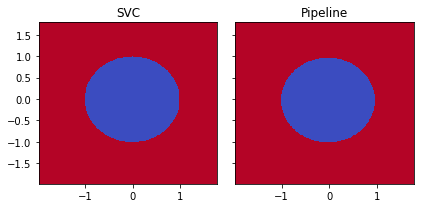

In [ ]:
k_logreg = pipeline.make_pipeline(PolyKernel(2), linear_model.LogisticRegression())
shootout_fancy = [svm.SVC(kernel='poly', degree=2), k_logreg]
fig, axes = plt.subplots(1,2,figsize=(6,3), sharey=True)
for mod, ax in zip(shootout_fancy, axes):
    plot_boundary(ax, data, tgt, mod, [0,1])
    ax.set_title(get_model_name(mod))
plt.tight_layout()

Visualizing SVM Kernel Differences

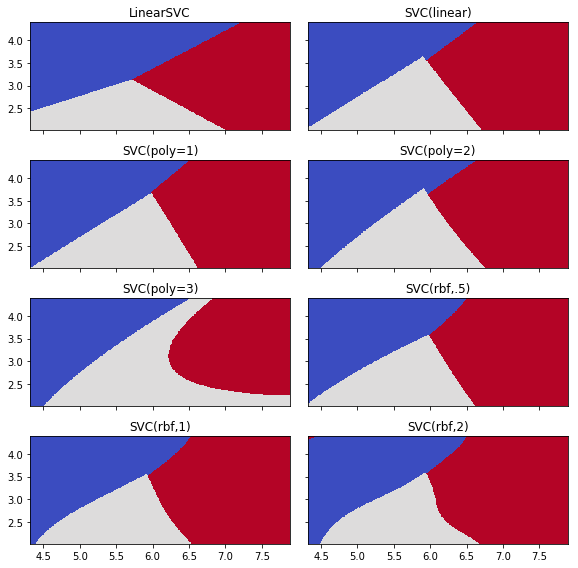

In [ ]:
sv_classifiers = {"LinearSVC"    : svm.LinearSVC(),
                   "SVC(linear)" : svm.SVC(kernel='linear'),
                   "SVC(poly=1)" : svm.SVC(kernel='poly', degree=1),
                   "SVC(poly=2)" : svm.SVC(kernel='poly', degree=2),
                   "SVC(poly=3)" : svm.SVC(kernel='poly', degree=3),
                   "SVC(rbf,.5)" : svm.SVC(kernel='rbf',  gamma=0.5),
                   "SVC(rbf,1)"  : svm.SVC(kernel='rbf',  gamma=1.0),
                   "SVC(rbf,2)"  : svm.SVC(kernel='rbf',  gamma=2.0),
                 }
fig, axes = plt.subplots(4,2,figsize=(8,8), sharex=True, sharey=True)
for ax , (name,mod) in zip(axes.flat, sv_classifiers.items()):
    plot_boundary(ax, iris.data, iris.target, mod, [0,1])
    ax.set_title(name)
plt.tight_layout()    

SVMs have lots of options. some advices when you want to use them:
1. Scale the data
2. USe an rbf kernel
3. Pick kernel parameters using cross validation
for rbf kernel, we need to select gamma, and C. 
Also some advices from ML community:
1. Use a linear kernel when the number of features is larger than number of observarions
2. USe an RBF kernel when number of observations is larger than number of features
3. If there are many observations, say more than 50k, consider using a linear kernel for speed

In [ ]:
digits = datasets.load_digits()
param_grid = {"gamma": np.logspace(-10,1,11, base=2), "C": [.5,1.0,2.0]}
svc = svm.SVC(kernel='rbf')
grid_model = skms.GridSearchCV(svc, param_grid = param_grid, cv=10, iid=False)
grid_model.fit(digits.data, digits.target)
grid_model.best_params_

{'C': 2.0, 'gamma': 0.0009765625}

In [ ]:
my_gamma = grid_model.best_params_['gamma']
my_svc = svm.SVC(kernel='rbf', **grid_model.best_params_)
scores = skms.cross_val_score(my_svc,digits.data, digits.target, cv=10, scoring='f1_macro')
print(scores)
print("{:5.3f}".format(scores.mean()))

[0.9672 1.     0.9493 0.9944 0.9829 0.9887 0.9944 0.9944 0.9766 0.9658]
0.981


#### PCA

In [ ]:
data = np.array([[1,2,4,5],[2.5,.75,5.25,3.5]]).T
mean = data.mean(axis=0)
centered_data = data - mean

TypeError: set_position() takes 2 positional arguments but 3 were given

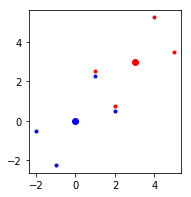

In [ ]:
fig, ax = plt.subplots(figsize=(3,3))
# original data in red, mean is larger dot at (3,3)
ax.plot(*data.T,'r.')
ax.plot(*mean,'ro')

#centered data in blue, mean at (0,0)
ax.plot(*centered_data.T, 'b.')
ax.plot(*centered_data.mean(axis=0), 'bo')

ax.set_aspect('equal')
high_school_style(ax)

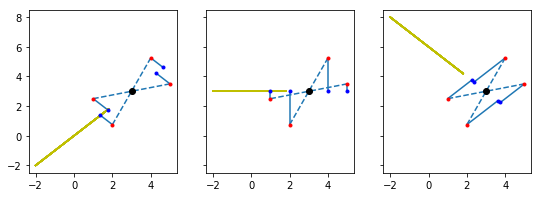

In [ ]:
def plot_lines_and_projections(axes,lines,points,xs):
        data_xs, data_ys = points[:,0], points[:,1]
        mean = np.mean(points,axis=0,keepdims = True)
        centered_data = points - mean
        for (m,b) , ax in zip(lines,axes):
            mb_line = m*xs + b
            v_line = np.array([[1,1/m if m else 0]])
            ax.plot(data_xs,data_ys,'r.')
            ax.plot(xs,mb_line,'y')
            ax.plot(*mean.T, 'ko')
            y_lengths = centered_data.dot(v_line.T)/v_line.dot(v_line.T)
            projs = y_lengths.dot(v_line)
            final = projs + mean
            ax.plot(*final.T,'b.')
            from matplotlib import collections as mc
            proj_lines = mc.LineCollection(zip(points,final))
            ax.add_collection(proj_lines)
            hypots = zip(points,np.broadcast_to(mean,points.shape))
            mean_lines = mc.LineCollection(hypots,linestyles = 'dashed')
            ax.add_collection(mean_lines)
fig, axes = plt.subplots(1,3, figsize=(9,3), sharex=True, sharey=True)
xp = np.linspace(0,6,30)
lines = [(1,0),(0,3),(-1,6)]
data = np.array([[1,2,4,5],[2.5,.75,5.25,3.5]]).T
plot_lines_and_projections(axes, lines, data, xs)

##### A first PCA

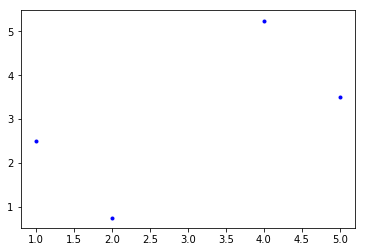

In [ ]:
# draw data
ax = plt.gca()
ax.scatter(data[:,0], data[:,1], c='b', marker='.')


In [ ]:
# draw mean
mean = np.mean(data, axis = 0, keepdims = True)
centered_data = data - mean
ax.scatter(*mean.T, c='k')

In [ ]:
# Compute PCA
pca = decomposition.PCA()
p = pca.fit_transform(centered_data)

In [ ]:
# extract usefull bits for drawing
directions = pca.components_
lengths = pca.explained_variance_
print("Lengths:", lengths)
var_wgt_prindirs = -np.diag(lengths).dot(directions) # negate to point up/right
print (var_wgt_prindirs)


Lengths: [5.6067 1.2683]
[[ 3.8682  4.0586]
 [-0.9181  0.875 ]]


In [ ]:
# draw principal axes
def sane_quiver(vs, ax=None, colors=None, origin=(0,0)):
    vs = np.arange(vs)
    assert vs.ndim ==2 and vs.shape[1] ==2 
    n = vs.shape[0]
    if not ax: ax = plt.gca()
    orig_x, orig_y = origin
    xs = vs.T[0]
    ys = vs.T[1]
    props = {"angles":'xy',"scale":1,"scale_units": 'xy' }
    ax.quiver(orig_x,orig_y,xs,ys,color=colors,**props)
    ax.set_aspect('equal')
    _min,_max = min(vs.min(),0)-1, max(0,vs.max())+1
    ax.set_xlim(_min,_max)
    ax.set_ylim(_min,_max)
sane_quiver(var_wgt_prindirs, ax, origin = np.mean(data, axis=0),colors='r')
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_aspect('equal')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()